# 로지스틱 회귀

In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential      # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense           # 모델 객체에 학습을 위한 층을 쌓는다.
from tensorflow.keras.optimizers import RMSprop,SGD # 옵티마이저
from tensorflow.keras.losses import mse             # 활성화 함수
import pandas as pd 
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import helper
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


## #02. 데이터 준비


In [4]:
origin = pd.read_excel('https://data.hossam.kr/E05/titanic.xlsx')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


명목형 : Pclass Sex Cabin Embarked

## #03. 데이터 전처리

### 결측치 확인

In [5]:
origin.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
origin = origin.drop('Cabin',axis=1)


<Axes: xlabel='Age', ylabel='Count'>

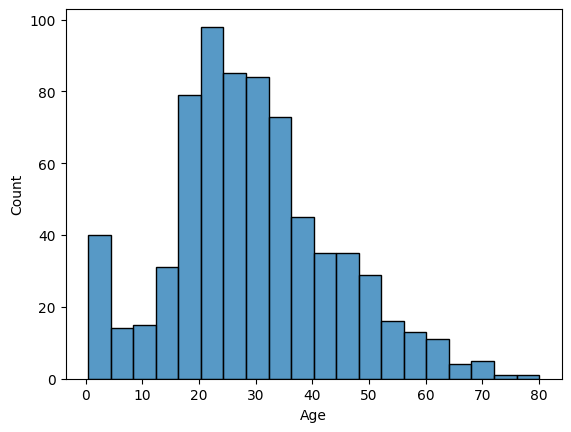

In [7]:
sns.histplot(x='Age',data=origin)
### 결측치를 중앙값으로 대체

In [8]:
origin['Age'] =origin['Age'].fillna(origin['Age'].median())
origin.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

<Axes: xlabel='Embarked', ylabel='count'>

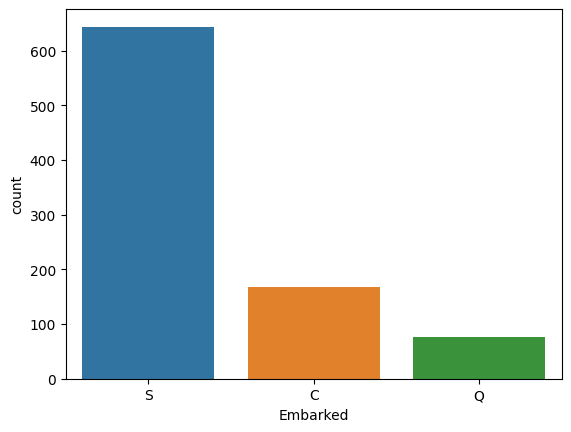

In [9]:
sns.countplot(x='Embarked',data=origin)
### 최반값으로 대체


In [14]:
origin['Embarked'] =origin['Embarked'].fillna('S') 

In [15]:
origin['Embarked'].mode()

0    S
Name: Embarked, dtype: object

In [16]:
origin.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [17]:
origin.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [18]:
df = origin.drop(['PassengerId','Name','Ticket'],axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### 명목형 변수에 대한 데이터 타입 설정

In [21]:
df['Pclass'] = df['Pclass'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')
df['Sex'] = df['Sex'].astype('category')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    category
 2   Sex       891 non-null    category
 3   Age       891 non-null    float64 
 4   SibSp     891 non-null    int64   
 5   Parch     891 non-null    int64   
 6   Fare      891 non-null    float64 
 7   Embarked  891 non-null    category
dtypes: category(3), float64(2), int64(3)
memory usage: 37.9 KB


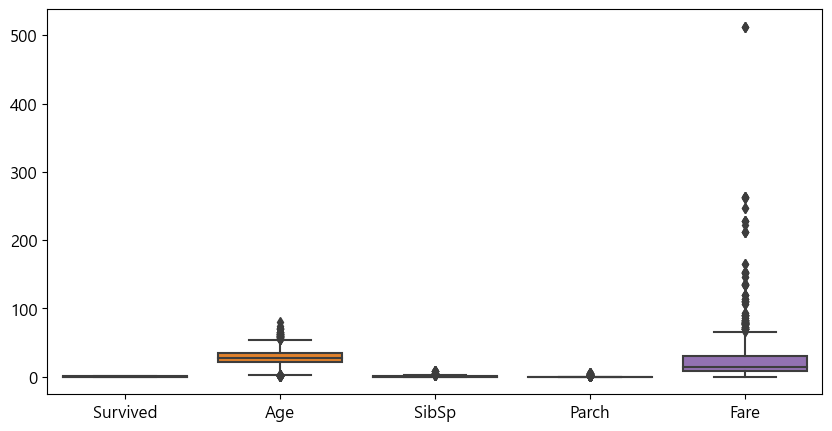

In [22]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,5))
sns.boxplot(data=df)
plt.show()
plt.close()

## #05. 데이터 셋 분할하기

In [23]:
np.random.seed(777)

### 종속 - 독립 분할

In [24]:
y=df[['Survived']]
x=df.drop('Survived',axis=1)



x.shape,y.shape

((891, 7), (891, 1))

### 데이터 표준화

In [26]:
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [28]:
num_col = ['Age','SibSp','Parch','Fare']


In [29]:
scaler = StandardScaler()
x.loc[:,num_col] =scaler.fit_transform(x.loc[:,num_col])
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,-0.565736,0.432793,-0.473674,-0.502445,S
1,1,female,0.663861,0.432793,-0.473674,0.786845,C
2,3,female,-0.258337,-0.474545,-0.473674,-0.488854,S
3,1,female,0.433312,0.432793,-0.473674,0.420730,S
4,3,male,0.433312,-0.474545,-0.473674,-0.486337,S


### 표준화 전 후 상자그림 비교

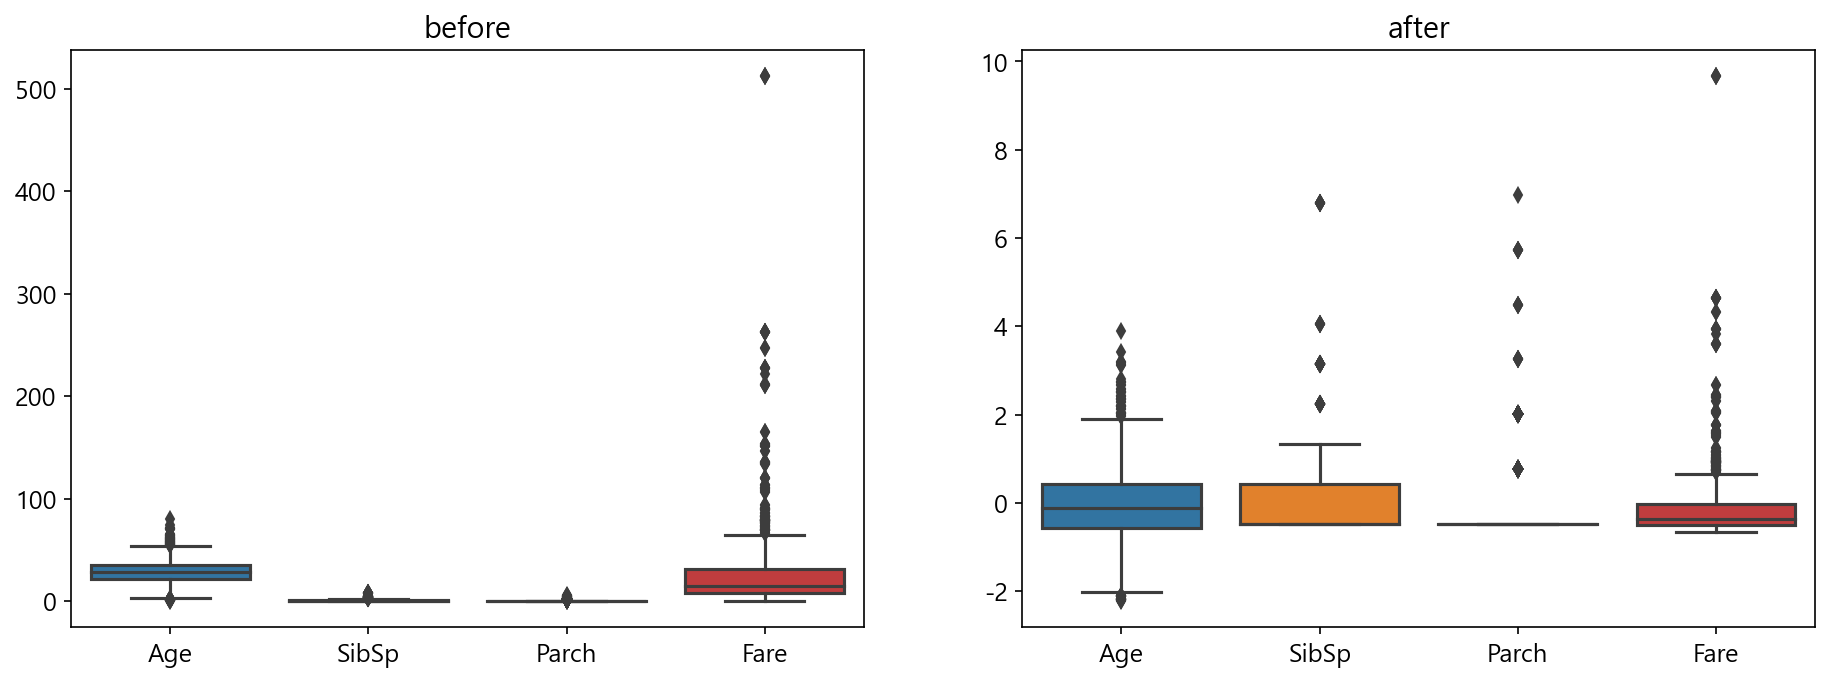

In [31]:
fig, ax = plt.subplots(1,2,figsize=(15,5),dpi=150)

sns.boxplot(data=df.loc[:,num_col],ax=ax[0])
sns.boxplot(data=x.loc[:,num_col],ax=ax[1])
ax[0].set_title('before')
ax[1].set_title('after')
plt.show()
plt.close()

### 훈련 - 검증 분할


In [32]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=2131)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((623, 7), (268, 7), (623, 1), (268, 1))

In [34]:
x_train = pd.get_dummies(x_train,drop_first=True,dtype='int')
x_test = pd.get_dummies(x_test,drop_first=True,dtype='int')
x_train.shape, x_test.shape

((623, 9), (268, 9))

## #06. 모델개발

### 모델정의

In [33]:
y_train.head()

,Survived
721,0
883,0
291,1
658,0
649,1


In [35]:
x_train.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
721,-0.949986,0.432793,-0.473674,-0.506388,0,1,1,0,1
883,-0.104637,-0.474545,-0.473674,-0.437007,1,0,1,0,1
291,-0.796286,0.432793,-0.473674,1.185430,0,0,0,0,0
658,-0.488887,-0.474545,-0.473674,-0.386671,1,0,1,0,1
649,-0.488887,-0.474545,-0.473674,-0.496405,0,1,0,0,1


In [39]:
model = Sequential()
model.add(Dense(81,activation='relu',input_shape=(9,)))
model.add(Dense(9,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['binary_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 81)                810       
                                                                 
 dense_7 (Dense)             (None, 9)                 738       
                                                                 
 dense_8 (Dense)             (None, 1)                 10        
                                                                 
Total params: 1558 (6.09 KB)
Trainable params: 1558 (6.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [40]:
result= model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),
callbacks = [
    EarlyStopping(monitor='val_loss',patience=5,verbose=1),
    ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.5,min_lir=0.0001)
])

Epoch 1/500
20/20 [==============================] - 4s 24ms/step - loss: 0.6456 - binary_accuracy: 0.6051 - val_loss: 0.5944 - val_binary_accuracy: 0.6679 - lr: 0.0010
Epoch 2/500
20/20 [==============================] - 0s 8ms/step - loss: 0.5892 - binary_accuracy: 0.6629 - val_loss: 0.5552 - val_binary_accuracy: 0.7276 - lr: 0.0010
Epoch 3/500
20/20 [==============================] - 0s 6ms/step - loss: 0.5546 - binary_accuracy: 0.7207 - val_loss: 0.5267 - val_binary_accuracy: 0.7649 - lr: 0.0010
Epoch 4/500
20/20 [==============================] - 0s 6ms/step - loss: 0.5279 - binary_accuracy: 0.7753 - val_loss: 0.5072 - val_binary_accuracy: 0.8022 - lr: 0.0010
Epoch 5/500
20/20 [==============================] - 0s 7ms/step - loss: 0.5072 - binary_accuracy: 0.7994 - val_loss: 0.4911 - val_binary_accuracy: 0.7985 - lr: 0.0010
Epoch 6/500
20/20 [==============================] - 0s 8ms/step - loss: 0.4881 - binary_accuracy: 0.7994 - val_loss: 0.4778 - val_binary_accuracy: 0.8284 - lr

## #07. 학습결과 평가


In [42]:
result.history

{'loss': [0.6455866098403931,
  0.5891745686531067,
  0.5546045303344727,
  0.5279020667076111,
  0.5072417855262756,
  0.4880999028682709,
  0.4735513925552368,
  0.46068835258483887,
  0.4519694447517395,
  0.44135451316833496,
  0.43305090069770813,
  0.42690590023994446,
  0.4231199622154236,
  0.4183461666107178,
  0.4146175980567932,
  0.41038641333580017,
  0.4080299437046051,
  0.4055720865726471,
  0.40238457918167114,
  0.40333735942840576,
  0.39759212732315063,
  0.3941955864429474,
  0.3922002613544464,
  0.3905215561389923,
  0.38950225710868835,
  0.3878701329231262,
  0.38690343499183655,
  0.3844155967235565,
  0.3827083706855774,
  0.3824024200439453,
  0.38105538487434387,
  0.3810694217681885,
  0.37946829199790955,
  0.37696540355682373,
  0.37493032217025757,
  0.3756025433540344,
  0.3734421730041504,
  0.3739645481109619,
  0.37123262882232666,
  0.3713739812374115,
  0.3679388463497162,
  0.36761656403541565],
 'binary_accuracy': [0.6051364541053772,
  0.662921

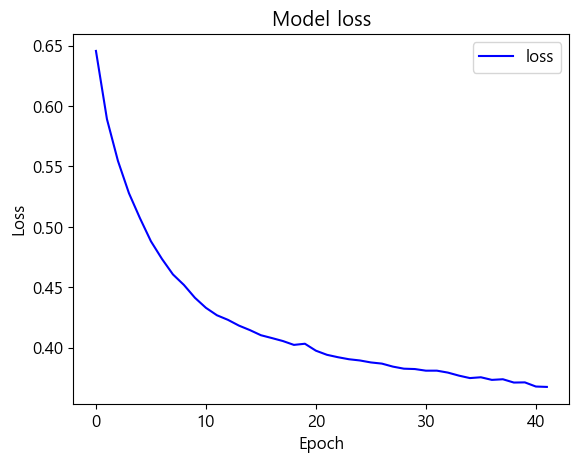

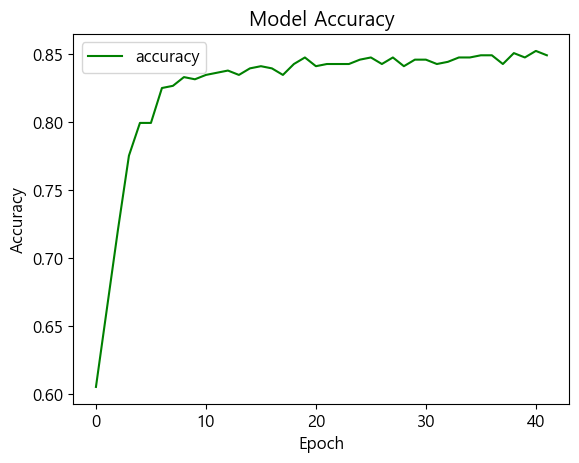

In [44]:
# 모델 손실 함수 시각화
plt.plot(result.history['loss'], 'b-', label='loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 정확도 시각화
plt.plot(result.history['binary_accuracy'], 'g-', label='accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [45]:
# # 손실 함수 계산
# model.evaluate(x_test, y_test, batch_size=1, verbose=2)

# # 모델 시각화
# line_x = np.arange(min(x_test), max(x_test), 0.01)
# line_y = model.predict(line_x)

# plt.plot(line_x, line_y, 'r-')
# plt.plot(x_test, y_test, 'bo')
# plt.title('Model')
# plt.xlabel('test')
# plt.ylabel('predict')
# plt.legend(['predict', 'test'], loc='upper left')
# plt.show()


In [47]:
result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs',inplace=True)
result_df

,loss,binary_accuracy,val_loss,val_binary_accuracy,lr
epochs,,,,,
1,0.645587,0.605136,0.594392,0.667910,0.0010
2,0.589175,0.662921,0.555249,0.727612,0.0010
3,0.554605,0.720706,0.526711,0.764925,0.0010
4,0.527902,0.775281,0.507247,0.802239,0.0010
5,0.507242,0.799358,0.491119,0.798507,0.0010
6,0.488100,0.799358,0.477778,0.828358,0.0010
7,0.473551,0.825040,0.469471,0.828358,0.0010
8,0.460688,0.826645,0.460943,0.828358,0.0010
9,0.451969,0.833066,0.453793,0.832090,0.0010


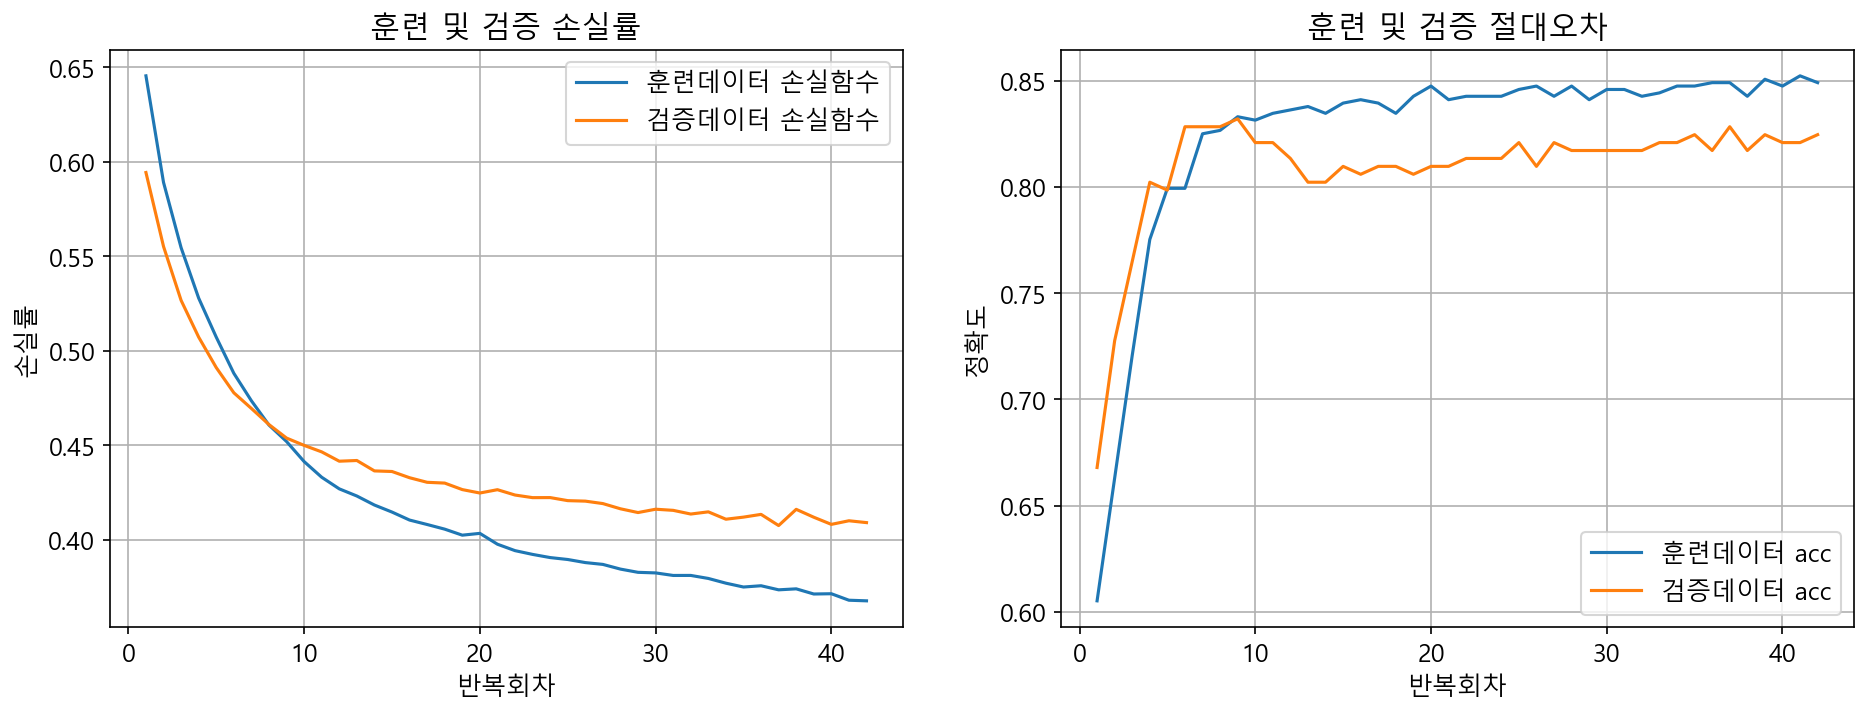

In [53]:
fig, ax = plt.subplots(1,2,figsize=(15,5),dpi = 150)

# 1) 훈련 및 검증데이터 손실함수 시각화
sns.lineplot(x=result_df.index, y='loss',data=result_df,label='훈련데이터 손실함수',ax=ax[0])
sns.lineplot(x=result_df.index,y='val_loss',data=result_df,label='검증데이터 손실함수',ax=ax[0])
ax[0].set_title('훈련 및 검증 손실률')
ax[0].set_xlabel('반복회차')
ax[0].set_ylabel('손실률')
ax[0].grid()
ax[0].legend()
# 2) 훈련 및 검증 절대오차 그리기
sns.lineplot(x=result_df.index , y='binary_accuracy',data=result_df,label='훈련데이터 acc',ax=ax[1])
sns.lineplot(x=result_df.index, y='val_binary_accuracy',data=result_df,label='검증데이터 acc',ax=ax[1])
ax[1].set_title('훈련 및 검증 절대오차')
ax[1].set_xlabel('반복회차')
ax[1].set_ylabel('정확도')
ax[1].grid()
ax[1].legend()

plt.show()
plt.close()



## #08. 학습결과 적용

### 예측결과 산정

In [56]:
x_train.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
721,-0.949986,0.432793,-0.473674,-0.506388,0,1,1,0,1
883,-0.104637,-0.474545,-0.473674,-0.437007,1,0,1,0,1
291,-0.796286,0.432793,-0.473674,1.185430,0,0,0,0,0
658,-0.488887,-0.474545,-0.473674,-0.386671,1,0,1,0,1
649,-0.488887,-0.474545,-0.473674,-0.496405,0,1,0,0,1


In [59]:
test_df = pd.DataFrame({
    'dicaprio': [19, 0, 0, 0, 0, 1, 1, 0, 0],  # 영화속 남자 주인공 데이터
    'winslet': [17, 1, 2, 100, 0, 0, 0, 1, 0], # 영화속 여자 주인공 데이터
    'someone': [41, 1, 0, 50, 1, 0, 1, 0, 0]  # 임의의 데이터
}, index=['Age','SibSp','Parch','Fare','Pclass_2','Pclass_3','Sex_male','Embarked_Q','Embarked_S'])
test_df = test_df.T
test_df.loc[:,num_col] = scaler.fit_transform(test_df.loc[:,num_col])
test_df.head() 

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
dicaprio,-0.613139,-1.414214,-0.707107,-1.224745,0,1,1,0,0
winslet,-0.797081,0.707107,1.414214,1.224745,0,0,0,1,0
someone,1.410220,0.707107,-0.707107,0.000000,1,0,1,0,0


### 예측하기

In [60]:
results = model.predict(test_df)
data_count,case_count = results.shape
print("%d개의 임의의 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(results)

1/1 [==============================] - 1s 975ms/step
3개의 임의의 데이터가 1개의 경우의 수를 갖는다.
[[0.24875756]
 [0.7706504 ]
 [0.13831636]]


In [62]:
for i , v in enumerate(results.flatten()):
    # print(i,v)
    print("%s의 생존 확률은 %0.1f%% 입니다." % (test_df.index[i], v*100))

dicaprio의 생존 확률은 24.9% 입니다.
winslet의 생존 확률은 77.1% 입니다.
someone의 생존 확률은 13.8% 입니다.


In [64]:
train_pred = model.predict(x_train)
train_pred

20/20 [==============================] - 0s 3ms/step


array([[0.15257469],
       [0.08219501],
       [0.90769947],
       [0.11229005],
       [0.58116156],
       [0.09280073],
       [0.09140113],
       [0.96232235],
       [0.12065454],
       [0.11778993],
       [0.1795987 ],
       [0.35188064],
       [0.05584878],
       [0.81307894],
       [0.1200185 ],
       [0.12087184],
       [0.12121984],
       [0.1147021 ],
       [0.02239996],
       [0.33160964],
       [0.8027392 ],
       [0.08543667],
       [0.9784053 ],
       [0.05624156],
       [0.0908158 ],
       [0.12138785],
       [0.12196108],
       [0.921432  ],
       [0.9194946 ],
       [0.5139424 ],
       [0.09280077],
       [0.11777673],
       [0.33315083],
       [0.923553  ],
       [0.24401678],
       [0.5046475 ],
       [0.3403398 ],
       [0.5951035 ],
       [0.09284784],
       [0.05478789],
       [0.73114043],
       [0.8026655 ],
       [0.8026655 ],
       [0.7688825 ],
       [0.92871684],
       [0.03644286],
       [0.10398801],
       [0.180

In [66]:
y_train

,Survived
721,0
883,0
291,1
658,0
649,1
...,...
652,0
791,0
608,1
621,1


In [67]:
rdf = pd.DataFrame({
    '결과값':y_train['Survived'].values,
    '예측치' :np.round(train_pred.flatten()),
    '합격확률':np.round(train_pred.flatten()*100,1)
})

rdf.head()

,결과값,예측치,합격확률
0,0,0.0,15.300000
1,0,0.0,8.200000
2,1,1.0,90.800003
3,0,0.0,11.200000
4,1,1.0,58.099998


### 혼동 행렬


In [69]:
cm = confusion_matrix(rdf['결과값'],rdf['예측치'])
tn,fp,fn,tp = cm.ravel()
cmdf = pd.DataFrame([[tn,fn],[fp,tp]],index=['True','False'],columns=['Negative','Positive'])
cmdf

,Negative,Positive
True,352,67
False,28,176


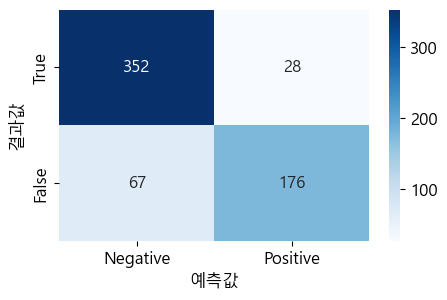

In [70]:
plt.figure(figsize=(5,3))
# 오차 행렬을 히트맵 그래프로 표현
# -> annot : 그래프의 각 칸에 수치값 출력
# -> fmt : 수치값 출력 format (여기서는 10진수)
# -> cmap : 색상맵 (<https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html>)
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['True', 'False'])
plt.xlabel('예측값')
plt.ylabel('결과값')
plt.show()

### 평가지표

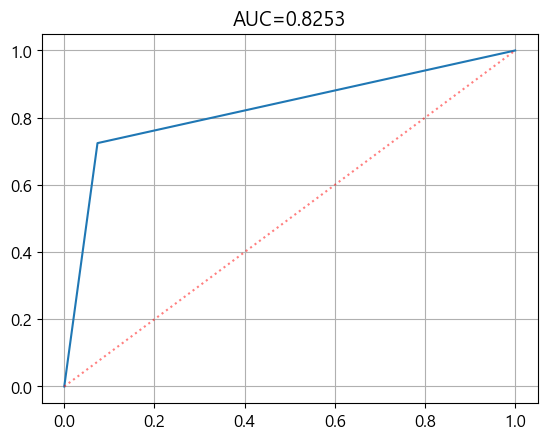

In [72]:
ras = roc_auc_score(rdf['결과값'],rdf['예측치'])

## fpr(위양성율),tpr(재현율),threshold (임계값)

fpr,tpr,threshold = roc_curve(rdf['결과값'],rdf['예측치'])
plt.figure()
sns.lineplot(x=fpr,y=tpr)
sns.lineplot(x=[0,1], y=[0,1], color='red', linestyle=':', alpha=0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()


In [ ]:
accuracy_score

In [75]:
acc = accuracy_score(rdf['결과값'],rdf['예측치'])

pre = precision_score(rdf['결과값'],rdf['예측치'])

recall = recall_score(rdf['결과값'],rdf['예측치'])

f1 = f1_score(rdf['결과값'],rdf['예측치'])

fallout = fp / (fp + tn)

spe = 1- fallout

result_df = pd.DataFrame({'정확도(Accuracy)':[acc], '정밀도(Precision)':[pre], '재현율(Recall, TPR)':[recall], '위양성율(Fallout, FPR)': [fallout], '특이성(Specificity, TNR)':[spe], 'RAS': [ras], 'f1_score':[f1]})

result_df


,정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",RAS,f1_score
0,0.847512,0.862745,0.72428,0.073684,0.926316,0.825298,0.787472


In [76]:
report = classification_report(rdf['결과값'], rdf['예측치'])
print(report)

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       380
           1       0.86      0.72      0.79       243

    accuracy                           0.85       623
   macro avg       0.85      0.83      0.83       623
weighted avg       0.85      0.85      0.84       623

